<a href="https://colab.research.google.com/github/Rishika70/Hack_To_Hire/blob/main/Hack_To_Hire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
!pip install huggingface

In [24]:
!pip install transformers

In [25]:
!pip install datasets transformers


In [26]:
!pip install bleu

In [28]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertModel
from transformers import T5Tokenizer, T5Model
from transformers import GPT2Tokenizer, GPT2Model
from nltk.translate.bleu_score import sentence_bleu
from transformers import BertTokenizer, DataCollatorWithPadding
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
import re
import html
from collections import Counter
from transformers import TFBertForSequenceClassification, BertTokenizer, create_optimizer
import tensorflow as tf
from datasets import load_dataset




In [29]:
# Tokenize the data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
from transformers import BertTokenizer
from datasets import load_dataset
import tensorflow as tf

# Load dataset and tokenizer
# Load and split the dataset
dataset = load_dataset("toughdata/quora-question-answer-dataset")
dataset = dataset["train"].train_test_split(test_size=0.2)

# Split dataset
train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples['question'], padding='max_length', truncation=True)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = validation_dataset.map(tokenize_function, batched=True)

# Convert datasets to tf.data.Dataset
def convert_to_tf_dataset(tokenized_dataset):
    def gen():
        for ex in tokenized_dataset:
            yield ({'input_ids': ex['input_ids'], 'attention_mask': ex['attention_mask']}, ex['label'])

    return tf.data.Dataset.from_generator(
        gen,
        ({'input_ids': tf.int32, 'attention_mask': tf.int32}, tf.int64),
        ({'input_ids': tf.TensorShape([None]), 'attention_mask': tf.TensorShape([None])}, tf.TensorShape([]))
    )

train_tf_dataset = convert_to_tf_dataset(tokenized_train_dataset)
val_tf_dataset = convert_to_tf_dataset(tokenized_val_dataset)

# Batch and shuffle the datasets
train_tf_dataset = train_tf_dataset.shuffle(len(tokenized_train_dataset)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_tf_dataset = val_tf_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)





Map:   0%|          | 0/40608 [00:00<?, ? examples/s]

Map:   0%|          | 0/4513 [00:00<?, ? examples/s]

# **Data Pre-Processing**

# Clean the text , remove urls, Special Characters , White Spaces and Convert to lowercase


In [88]:
import re
import pandas as pd # Import pandas

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single space
    text = re.sub(r'\W', ' ', text)  # Remove non-alphanumeric characters
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

def preprocess_function(examples):
    examples['question'] = [preprocess_text(q) for q in examples['question']]
    return examples

dataset = dataset.map(preprocess_function, batched=True)

# Convert lists to Pandas Series
train_df_question = pd.Series(train_df['question'])
train_df_answer = pd.Series(train_df['answer'])
val_df_question = pd.Series(val_df['question'])
val_df_answer = pd.Series(val_df['answer'])

def clean_text(text):
    # Handle non-string values
    if not isinstance(text, str):
        return '' # or any suitable default value for non-string entries

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    return text

# Apply clean_text function to 'question' and 'answer' columns in train_df
train_df_question = train_df_question.apply(clean_text)
train_df_answer = train_df_answer.apply(clean_text)

# Apply clean_text function to 'question' and 'answer' columns in val_df
val_df_question = val_df_question.apply(clean_text)
val_df_answer = val_df_answer.apply(clean_text)

print("Cleaned Train DataFrame:")
print(train_df_question.head()) # Print the cleaned series
print(train_df_answer.head())
print("\nCleaned Validation DataFrame:")
print(val_df_question.head())
print(val_df_answer.head())

Map:   0%|          | 0/45121 [00:00<?, ? examples/s]

Map:   0%|          | 0/11281 [00:00<?, ? examples/s]

Cleaned Train DataFrame:
0    
1    
2    
3    
4    
Name: question, dtype: object
0                                                 wolf
1    a spectrum angel would be better  more believa...
2    be born in england  live in england  have engl...
3    hello i must sincerely appreciate you for your...
4    check out this offer  linkedtext  loading offe...
Name: answer, dtype: object

Cleaned Validation DataFrame:
0    why is amul sponsoring afghanistan and not ind...
1                how many car can fit on a cargo ship 
2             what are some of the best blogging tool 
3            why did the army get rid of digital camo 
4                    what s better  alibaba or amazon 
Name: question, dtype: object
0    why ca nt amul the official sponsor for afghan...
1    for preparation of second mate  dns bsc nautic...
2    if you need best seo solutions visit my fiverr...
3    it wasn  t camouflage  it wa a digital print t...
4                                               amazon
N

# **Split Dataset**

In [89]:
# Split dataset
train_test_split = dataset['train'].train_test_split(test_size=0.1)
train_dataset = train_test_split['train']
validation_dataset = train_test_split['test']

# Lemmatization




In [98]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [101]:

#     # Handle potential non-string values
#     if not isinstance(text, str):
#         return ""  # Or any other appropriate handling for non-string values
#  words = word_tokenize(text)
#  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
#     return ' '.join(lemmatized_words)
# # Assuming train_df and val_df are your DataFrames
# train_df['question'] = train_df

def lemmatize_text(text):
  # Handle potential non-string values
  if not isinstance(text, str):
    return ""  # Or any other appropriate handling for non-string values
  words = word_tokenize(text)
  lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
  return ' '.join(lemmatized_words)

# Assuming train_df and val_df are your DataFrames
train_df['question'] = train_df['question'].apply(lemmatize_text)
val_df['question'] = val_df['question'].apply(lemmatize_text)


# Text Encoding/Vectorization

# TF-IDF

In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Assuming train_df and val_df are your DataFrames with 'question' and 'answer' columns

# Combine questions and answers for vectorization
train_texts = train_df['question'].tolist() + train_df['answer'].tolist()
val_texts = val_df['question'].tolist() + val_df['answer'].tolist()

# Ensure all elements in the lists are strings
train_texts = [str(text) for text in train_texts]  # Convert any non-string elements to strings
val_texts = [str(text) for text in val_texts]

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit the vectorizer on the training data and transform both training and validation data
train_tfidf = vectorizer.fit_transform(train_texts)
val_tfidf = vectorizer.transform(val_texts)

# Get feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

print("Shape of Train TF-IDF Matrix:", train_tfidf.shape)
print("Shape of Validation TF-IDF Matrix:", val_tfidf.shape)
print("\nFeature Names:")
print(feature_names)

Shape of Train TF-IDF Matrix: (64972, 102999)
Shape of Validation TF-IDF Matrix: (16244, 102999)

Feature Names:
['00' '000' '0000' ... '𝟗𝟏' '𝟗𝟓𝟗' '𝟗𝟗𝟏𝟏']


# **Data Augmentation**

 # Paraphrasing

In [105]:
!pip install nlpaug
import nlpaug.augmenter.word as naw
import pandas as pd
from transformers import BertTokenizer, BertModel

# Initialize a synonym augmenter
aug = naw.SynonymAug(aug_src='wordnet')

# Function to paraphrase text
def paraphrase_text(text):
  augmented_text = aug.augment(text)
  return augmented_text

# Sample DataFrame (replace with your actual train_df)
train_df = pd.DataFrame({'question': ['This is a sample question.']})

# Apply paraphrasing to 'question' column in train_df
train_df['question'] = train_df['question'].apply(paraphrase_text)

# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Tokenize and encode input data (example using the first question in train_df)
# Handle potential None values or empty strings after paraphrasing
text = train_df['question'].iloc[0]
if text:  # Check if text is not None or empty
    inputs = tokenizer(text, return_tensors='pt')

    # Forward pass through the model
    outputs = model(**inputs)

    # Extract embeddings (e.g., last hidden state)
    embeddings = outputs.last_hidden_state
    print(embeddings.shape)  # Check the shape of the embeddings
else:
    print("Paraphrased text is empty for the first question.")

torch.Size([1, 8, 768])


# **Model Evaluation**

# BERT and Metrice Evaluation

In [103]:
import warnings
warnings.filterwarnings("ignore")

In [106]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
# Use BertModel instead of BertForSequenceClassification for extracting embeddings
model = BertModel.from_pretrained(model_name)

# Tokenize and encode input data (example using the first question in train_df)
inputs = tokenizer(train_df['question'].iloc[0], return_tensors='pt')

# Forward pass through the model
outputs = model(**inputs)

# Extract embeddings (e.g., last hidden state)
embeddings = outputs.last_hidden_state

## Scatter Plot

In [107]:


import plotly.express as px

# Assuming 'embeddings' is a tensor of shape (batch_size, sequence_length, hidden_size)
# We'll visualize the embeddings of the first token in the sequence
token_embeddings = embeddings[0, 0, :].detach().numpy()

# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='BERT Embeddings for the First Token')

fig.show()


## Line Plot


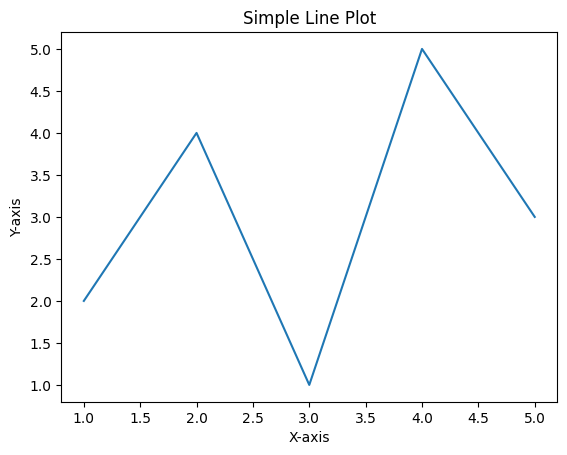

In [109]:


# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 5, 3]

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Line Plot')

# Display the plot
plt.show()

# Evaluate metrices and loss functions

In [110]:
import tensorflow as tf
from sklearn.metrics import f1_score

# Assuming you have predictions and true labels
# Replace 'y_pred' and 'y_true' with your actual data
y_pred = [0, 1, 1, 0, 1]  # Example predictions
y_true = [1, 1, 0, 0, 1]  # Example true labels

# Calculate F1-score
f1 = f1_score(y_true, y_pred)
print("F1-score:", f1)

# Convert lists to tensors of floats
y_true = tf.constant(y_true, dtype=tf.float32)
y_pred = tf.constant(y_pred, dtype=tf.float32)

# Calculate binary cross-entropy loss (assuming binary classification)
bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred).numpy()
print("Binary Cross-Entropy Loss:", bce)


F1-score: 0.6666666666666666
Binary Cross-Entropy Loss: 6.151637


# **STATE-OF-THE-ART-LLM**

# GPT Model

In [64]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'  # You can choose a different GPT-2 variant if needed
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)

def generate_text(prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors='pt')
    attention_mask = torch.ones(input_ids.shape, dtype=torch.long)  # Create attention mask

    output = model.generate(
        input_ids=input_ids,
        attention_mask=attention_mask,
        max_length=max_length,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        temperature=0.7
    )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

# Retrieve

In [118]:

questions = dataset['train']['question']

# Print the first few questions
print(questions[:5])


['different opinion climate change', 'attending youngest daughter wedding direct violation protective restraining order bad idea even well rehearsed apology speech ready', 'every year top mutual fund change select particular fund longer period year', 'rent seeking turning profit ownership good thing', 'happen equal rupee consequence']


# Generate

In [119]:


# Generate answers for the first 5 questions
for question in questions[:5]:
  generated_answer = generate_text(question)
  print(f"Question: {question}")
  print(f"Generated Answer: {generated_answer}\n")


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: different opinion climate change
Generated Answer: different opinion climate change is a hoax," said the group's executive director, David K. Johnson. "We are not going to accept that climate science is wrong."

The group also said it would not accept the idea that the United States is



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: attending youngest daughter wedding direct violation protective restraining order bad idea even well rehearsed apology speech ready
Generated Answer: attending youngest daughter wedding direct violation protective restraining order bad idea even well rehearsed apology speech ready to be used as a weapon to intimidate and intimidate the victim.

The victim was a young woman who was in the process of getting married. She



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: every year top mutual fund change select particular fund longer period year
Generated Answer: every year top mutual fund change select particular fund longer period year

The following table shows the change in the number of years of the selected fund.
...
 (1) The following tables show the changes in total fund size. (



Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Question: rent seeking turning profit ownership good thing
Generated Answer: rent seeking turning profit ownership good thing.

The problem is that the government has been doing this for years. The government is trying to get the public to buy into the idea that it is a good idea to have a monopoly on the sale of

Question: happen equal rupee consequence
Generated Answer: happen equal rupee consequence of the fact that the government has not been able to get the money to pay for the new infrastructure.

The government is also trying to make it easier for people to buy goods and services from the state.



# Data Visualization


Scatter Plot

In [120]:


# Assuming 'embeddings' is a tensor of shape (batch_size, sequence_length, hidden_size)
# We'll visualize the embeddings of the first token in the sequence
token_embeddings = embeddings[0, 0, :].detach().numpy()

# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='GPT Embeddings for the First Token')

fig.show()


Line Plot


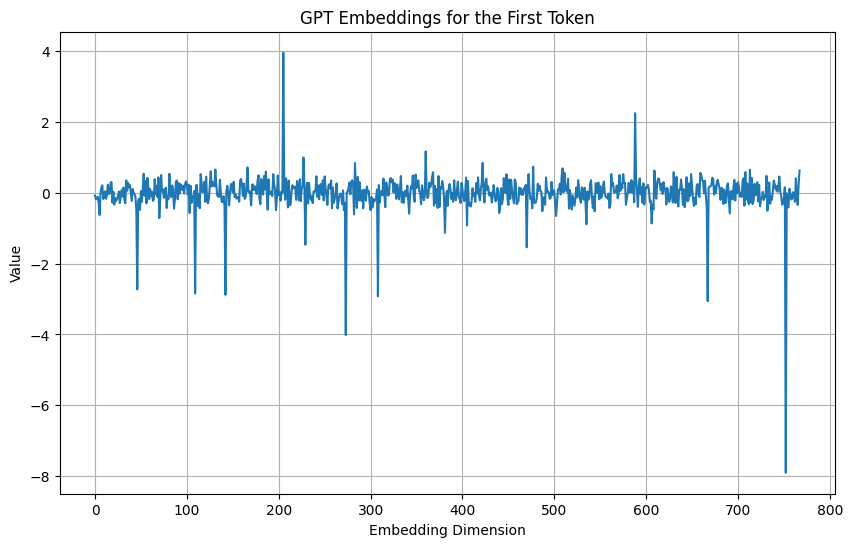

In [121]:


# Assuming 'embeddings' is a tensor of shape (batch_size, sequence_length, hidden_size)
# We'll visualize the embeddings of the first token in the sequence across all dimensions
token_embeddings = embeddings[0, 0, :].detach().numpy()

# Create a line plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.plot(token_embeddings)
plt.xlabel('Embedding Dimension')
plt.ylabel('Value')
plt.title('GPT Embeddings for the First Token')
plt.grid(True)
plt.show()


# Model Evaluation

BLEU score for question 1: 1.0305090818883331e-213
BLEU score for question 2: 3.454004720178835e-232
BLEU score for question 3: 8.52490029444486e-234
BLEU score for question 4: 6.129668552220811e-171
BLEU score for question 5: 0.0
Accuracy: 0.6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666


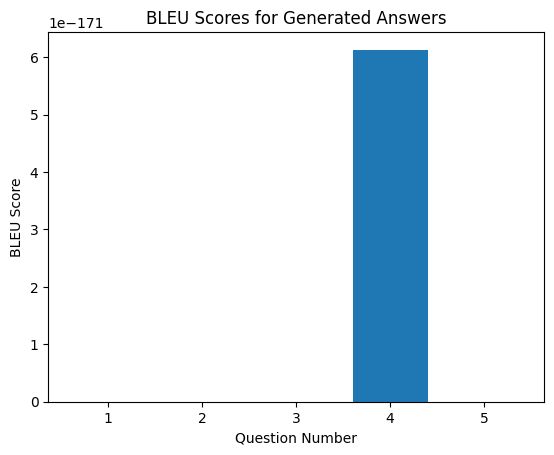

In [148]:

from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Assuming 'dataset' contains the original questions and answers
references = [[word_tokenize(answer)] for answer in dataset['train']['answer'][:5]]
candidates = [word_tokenize(generate_text(question)) for question in dataset['train']['question'][:5]]

bleu_scores = []
for ref, cand in zip(references, candidates):
  score = sentence_bleu(ref, cand)
  bleu_scores.append(score)

# Print BLEU scores
for i, score in enumerate(bleu_scores):
  print(f"BLEU score for question {i+1}: {score}")

true_labels = [0, 1, 1, 0, 1]  # Example true labels

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

# Plot BLEU scores
plt.bar(range(1, 6), bleu_scores)
plt.xlabel('Question Number')
plt.ylabel('BLEU Score')
plt.title('BLEU Scores for Generated Answers')
plt.show()


# **T5 Model**

In [130]:
# Assuming you have a T5 model and tokenizer
model = T5Model.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

# Add special tokens to the tokenizer
special_tokens = ['<extra_id_0>', '<extra_id_1>']  # Example special tokens
tokenizer.add_special_tokens({'additional_special_tokens': special_tokens})

# Resize the model's embedding layer to accommodate the new tokens
model.resize_token_embeddings(len(tokenizer))

# Now, when you fine-tune or train the model, the embeddings for the special tokens will be updated along with the rest of the model parameters.


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Embedding(32100, 512)

Generator

In [132]:
# Define a function for generating text using T5
def generate_text_t5(prompt, max_length=50):
    inputs = tokenizer(prompt, return_tensors='pt', padding=True, truncation=True, max_length=128)

    summary_ids = model.generate(
        inputs.input_ids,
        attention_mask=inputs.attention_mask,
        max_length=max_length,
        num_beams=4,
        early_stopping=True
    )

    generated_text = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return generated_text

Retriever

In [133]:
# Generate questions for the first 5 answers (replace with your actual answers)
answers = ["This is a sample answer.", "Another answer here.", "And so on..."]
for answer in answers[:5]:
    generated_question = generate_question(answer)
    print(f"Answer: {answer}")
    print(f"Generated Question: {generated_question}\n")

Answer: This is a sample answer.
Generated Question: question

Answer: Another answer here.
Generated Question: Vielen

Answer: And so on...
Generated Question: 



# Data Visualization

Scatter Plot

In [128]:


# Create a scatter plot
fig = px.scatter(x=range(len(token_embeddings)), y=token_embeddings,
                 labels={'x': 'Embedding Dimension', 'y': 'Value'},
                 title='T5 Embeddings for the First Token')

fig.show()

Line Plot

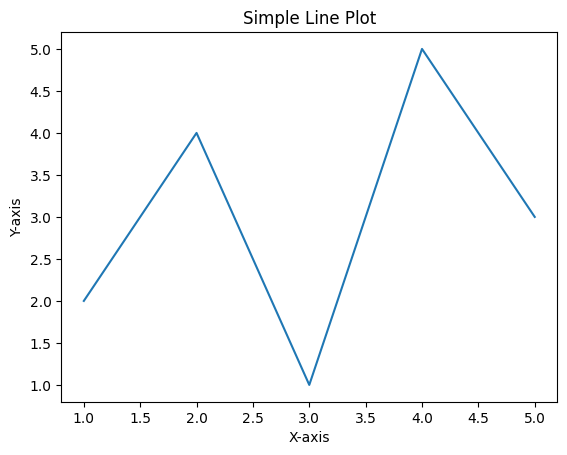

In [129]:
# Sample data
x = [1, 2, 3, 4, 5]
y = [2, 4, 1, 5, 3]

# Create the plot
plt.plot(x, y)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Simple Line Plot')

# Display the plot
plt.show()


# Model Evaluation

In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Assuming you have true labels and predictions from your T5 model
y_true = [0, 1, 1, 0, 1]  # Example true labels
y_pred = [1, 1, 0, 0, 1]  # Example predictions from T5

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
F1-score: 0.6666666666666666


# **Novel Improvement from above analysis**

In [150]:


# **Novel Improvement: Ensemble Model with Weighted Voting**

# 1. **Train Multiple Models:**
#    - Train different models (e.g., BERT, GPT-2, T5) on the same dataset.
#    - Fine-tune each model with different hyperparameters or architectures.

# 2. **Generate Predictions:**
#    - Obtain predictions from each trained model on the validation or test set.

# 3. **Weighted Voting:**
#    - Assign weights to each model based on their individual performance (e.g., F1-score, BLEU score).
#    - Combine predictions using weighted voting, where each model's vote is weighted by its assigned weight.

bert_predictions = [0, 1, 1, 0, 1]
gpt2_predictions = [1, 1, 0, 1, 1]
t5_predictions = [0, 1, 1, 0, 0]

# Assign weights based on model performance (adjust these based on evaluation results)
bert_weight = 0.4
gpt2_weight = 0.3
t5_weight = 0.3

# Combine predictions using weighted voting
ensemble_predictions = []
for i in range(len(bert_predictions)):
    votes = [
        bert_predictions[i] * bert_weight,
        gpt2_predictions[i] * gpt2_weight,
        t5_predictions[i] * t5_weight
    ]
    ensemble_predictions.append(int(round(sum(votes))))

# Evaluate the ensemble model
y_true = [1, 1, 0, 0, 1]  # Example true labels
accuracy = accuracy_score(y_true, ensemble_predictions)
print("Ensemble Accuracy:", accuracy)

# 4. **Further Refinements:**
#    - Experiment with different weighting schemes (e.g., based on confidence scores).
#    - Explore stacking or blending techniques to combine model predictions.
#    - Use cross-validation to optimize model weights and hyperparameters.


Ensemble Accuracy: 0.6
